In [ ]:
# prompt: install tensorflow version 2.15

!pip install tensorflow==2.15


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

data_dir = ""
model_dir = ""
figure_dir = ""

def load_face_data():
    train = np.load(data_dir+"train.npz")
    test = np.load(data_dir+"test.npz")

    return train, test

def split_face_data(train, test, key="img_224"):

    X = train[key]
    y = train["labels"].reshape(-1).astype(np.int32)

    test_X = test[key]
    test_y = test["labels"].reshape(-1).astype(np.int32)

    indices = np.arange(len(X))
    np.random.seed(123)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    age = np.minimum(train["ages"].reshape(-1)[indices] // 20, 4)

    combined_data = np.column_stack((y, age))
    stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2,  random_state=123)

    # Perform stratified split
    for train_index, val_index in stratified_splitter.split(combined_data, combined_data[:, 0]):
        train_img, valid_img = X[train_index], X[val_index]
        train_labels, valid_labels = y[train_index], y[val_index]

    t_total  = len(train_labels)
    t_P = train_labels.sum()
    t_N = t_total - t_P

    v_total = len(valid_labels)
    v_P = valid_labels.sum()
    v_N = v_total - v_P

    print("X_train shape:", train_img.shape)
    print("y_train shape:", train_labels.shape)
    print("X_val shape:", valid_img.shape)
    print("y_val shape:", valid_labels.shape)
    print("train P:{:.4f}, N:{:.4f}, total:{}".format(t_P/t_total, t_N/t_total, t_total))
    print("valid P:{:.4f}, N:{:.4f}, total:{}".format(v_P/v_total, v_N/v_total, v_total))

    return train_img, train_labels, valid_img, valid_labels, test_X, test_y

def load_models():
    print("start loading model")
    finetuning = keras.models.load_model(model_dir+"new_finetuning")
    freeze = keras.models.load_model(model_dir+"new_freeze")
    simple_224 = keras.models.load_model(model_dir+"new_simple_224")
    simple_112 = keras.models.load_model(model_dir+"new_simple_112")
    print("end loading model")
    return finetuning, freeze, simple_224, simple_112

In [ ]:
# @title evaluate
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn


class evaluate:
  def __init__(self, labels, predict, val_labels, val_predict, sex, age):
    self.labels = labels.squeeze()
    self.predict = predict.squeeze()
    self.val_labels = val_labels.squeeze()
    self.val_predict = val_predict.squeeze()
    self.figsize = (10, 10)
    self.threshold = 0.5
    self.sex = sex
    self.age = age

  def set_threshold(self):
    # calculate Youden’s index in valid set
    val_label = self.val_labels.squeeze()
    val_predict = self.val_predict.squeeze()
    def calculate_Y_index(threshold):
      TP = np.logical_and(val_label >= threshold, val_predict >= threshold).sum()
      TN = np.logical_and(val_label < threshold, val_predict <  threshold).sum()
      FP = np.logical_and(val_label < threshold, val_predict >= threshold).sum()
      FN = np.logical_and(val_label >= threshold, val_predict <  threshold).sum()

      assert TP + FN + TN + FP == len(val_label)
      assert TP + FN == val_label.sum()
      assert TN + FP == len(val_label) - val_label.sum()
      Sensitivity = TP / (TP + FN)
      Specificity = TN / (FP + TN)
      return Sensitivity + Specificity

    thresholds = np.sort(val_predict)[1:-1]
    y = np.vectorize(calculate_Y_index)(thresholds)
    self.threshold = thresholds[np.argmax(y)]


  def result(self, labels, predict):
    if len(labels) == 0 or len(scores) == 0:
      labels = self.labels
      predict = self.predict

    labels = labels.squeeze()
    predict = predict.squeeze()
    assert len(labels) == len(predict)

    threshold = self.threshold

    acc = accuracy_score(labels, predict>=threshold)
    auc = roc_auc_score(labels, predict)

    acc = round(acc, 4)
    auc = round(auc, 4)

    print(labels.shape, predict.shape)
    cm = confusion_matrix(labels, predict >= self.threshold)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    print(f"{TP=}, {TN=}, {FP=}, {FN=}")


    assert TP + FN == labels.sum()
    assert TN + FP == labels.shape[0] - labels.sum()

    Sensitivity = round(TP / (TP + FN), 4)
    Specificity = round(TN / (FP + TN), 4)
    if TP + FP == 0 or TN + FN == 0:
      PPV = None
      NPV = None
    else:
      PPV = round(TP / (TP + FP), 4)
      NPV = round(TN / (TN + FN), 4)

    return (Sensitivity, Specificity, PPV, NPV, acc, auc)
def group_age_sex(arr, age, sex):

    predict_0_19 =  arr[age<20]
    predict_20_39 = arr[np.logical_and(age>=20, age <40)]
    predict_40_59 = arr[np.logical_and(age>=40, age <60)]
    predict_60 = arr[age>=60]
    predict_20 = arr[age>=20]
    predict_M = arr[sex=='남']
    predict_F = arr[sex=='여']

    return (predict_0_19, predict_20_39, predict_40_59, predict_60, predict_20, predict_M, predict_F)


In [ ]:
# @title function for statistical test
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


def bootstrap_auc(labels : np.ndarray, scores : np.ndarray, n_bootstraps=100000):
    # Calculate AUC for the bootstrap sample
    # Resample scores and labels with replacement
    bootstrap_aucs = []

    for i in range(n_bootstraps):
        if (i+1) % (n_bootstraps//10) ==0:
            print(f"{(i+1)/n_bootstraps*100}%, ", end="")
        # Resample scores and labels with replacement
        indices = resample(np.arange(len(labels)))
        boot_scores = scores[indices]
        boot_labels = labels[indices]

        # Calculate AUC for the bootstrap sample
        auc = roc_auc_score(boot_labels, boot_scores)
        bootstrap_aucs.append(auc)
    print()

    return np.array(bootstrap_aucs)

def CI(metric):
    ci_lower = np.percentile(metric, 2.5)
    ci_upper = np.percentile(metric, 97.5)
    return ci_lower, ci_upper

import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions.
    """
    ground_truth = ground_truth.astype(np.float64)
    order = np.argsort(predictions)[::-1]
    predictions = predictions[order]
    ground_truth = ground_truth[order]
    distinct_value_indices = np.where(np.diff(predictions))[0]
    distinct_value_indices = np.concatenate(([0], distinct_value_indices + 1))
    tps = np.cumsum(ground_truth)[distinct_value_indices]
    fps = 1 + distinct_value_indices - tps
    tps = np.concatenate(([0.], tps))
    fps = np.concatenate(([0.], fps))
    if tps[-1] == 0:
        raise ValueError("The last value of tps is zero, indicating no positive instances in ground truth.")
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]
    return tpr, fpr

def calc_auc_variance(ground_truth, predictions):
    """
    Calculates AUC and its variance for a set of predictions.
    """
    auc = roc_auc_score(ground_truth, predictions)
    tpr, fpr = delong_roc_variance(ground_truth, predictions)
    v01 = tpr * (1 - tpr) / len(ground_truth[ground_truth == 1])
    v10 = fpr * (1 - fpr) / len(ground_truth[ground_truth == 0])
    auc_variance = np.sum(v01 + v10)
    return auc, auc_variance

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Performs DeLong's test for two correlated ROC AUCs.
    """
    auc1, var1 = calc_auc_variance(ground_truth, predictions_one)
    auc2, var2 = calc_auc_variance(ground_truth, predictions_two)
    if len(predictions_one) <= 1 or len(predictions_two) <= 1:
        raise ValueError("Not enough data points to calculate covariance.")
    cov = np.cov(predictions_one, predictions_two, ddof=1)[0, 1]
    z = (auc1 - auc2) / np.sqrt(var1 + var2 - 2 * cov)
    p_value = norm.sf(abs(z)) * 2  # Two-tailed test
    return z, p_value



In [ ]:
# @title load data and split and load model
import os
import numpy as np

train, test = load_face_data()
train_img, train_labels, valid_img, valid_labels, test_X, test_y = split_face_data(train, test)

test_ages = test['ages']
test_sexs = test['sexs']

finetuning, freeze, simple_224, _ = load_models()


if not os.path.isfile(data_dir+"scores.npz"):
    scores = {}
    scores['finetuning'] = finetuning.predict(test_X)
    scores['freeze'] = freeze.predict(test_X)
    scores['simple_224'] = simple_224.predict(test_X)
    # scores['simple_112'] = simple_112.predict(test_X)

    np.savez_compressed(data_dir+"scores.npz", **scores)

if not os.path.isfile(data_dir+"val_scores.npz"):
    val_scores = {}
    scores['finetuning'] = finetuning.predict(valid_img)
    scores['freeze'] = freeze.predict(valid_img)
    scores['simple_224'] = simple_224.predict(valid_img)
    # scores['simple_112'] = simple_112.predict(valid_img)

    np.savez_compressed(data_dir+"val_scores.npz", **scores)

scores = np.load(data_dir+"scores.npz")
val_scores = np.load(data_dir+"val_scores.npz")

finetuning.layers[-1].activation = None
simple_224.layers[-1].activation = None

finetuning.compile()
simple_224.compile()

X_train shape: (2317, 224, 224, 3)
y_train shape: (2317,)
X_val shape: (580, 224, 224, 3)
y_val shape: (580,)
train P:0.5585, N:0.4415, total:2317
valid P:0.5586, N:0.4414, total:580
start loading model
end loading model


In [ ]:
finetuning.summary()
simple_224.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0   

In [ ]:
# @title statistical test
import numpy as np
import numpy as np
from scipy.stats import chi2
from sklearn.metrics import roc_auc_score

def calculate_covariance(y_true, y_scores):
    m = len(y_true)
    order = np.argsort(y_scores)[::-1]
    y_true = y_true[order]
    y_scores = y_scores[order]

    pos_count = np.sum(y_true)
    neg_count = m - pos_count

    rank = np.arange(1, m + 1)
    pos_rank = rank[y_true == 1]
    neg_rank = rank[y_true == 0]

    V10 = (pos_rank - np.arange(1, pos_count + 1)).sum() / pos_count
    V01 = (neg_rank - np.arange(1, neg_count + 1)).sum() / neg_count

    var = (V10 / pos_count + V01 / neg_count) / m

    return var

def delong_test_multiple(groups, y_true_dict, y_scores_dict):
    aucs = []
    variances = []

    for group in groups:
        y_true = y_true_dict[group]
        y_scores = y_scores_dict[group]

        auc = roc_auc_score(y_true, y_scores)
        var = calculate_covariance(np.array(y_true), np.array(y_scores))

        aucs.append(auc)
        variances.append(var)

    aucs = np.array(aucs)
    variances = np.array(variances)

    mean_auc = np.mean(aucs)

    # Compute the test statistic
    k = len(groups)
    statistic = np.sum(((aucs - mean_auc) ** 2) / variances)

    # Determine the p-value
    p_value = 1 - chi2.cdf(statistic, k-1)

    return statistic, p_value


# Prepare data
groups = ['Under 20', '20 - 39', '40 - 59', 'Over 60']
label_group = group_age_sex(test_y, test_ages.squeeze(), test_sexs.squeeze())
score_group = group_age_sex(scores["finetuning"].squeeze(), test_ages.squeeze(), test_sexs.squeeze())
y_true_dict = {
    'Under 20': label_group[0],
    '20 - 39': label_group[1],
    '40 - 59': label_group[2],
    'Over 60': label_group[3]
}
y_scores_dict = {
    'Under 20': score_group[0],
    '20 - 39': score_group[1],
    '40 - 59': score_group[2],
    'Over 60': score_group[3]
}

statistic, p_value = delong_test_multiple(groups, y_true_dict, y_scores_dict)
print(f'Statistic: {statistic}, p-value: {p_value}')

Statistic: 0.3759843079198064, p-value: 0.9451576478290505


In [ ]:
groups = ['Male', 'Female']
y_true_dict = {
    'Male': label_group[5],
    'Female': label_group[6],
}
y_scores_dict = {
    'Male': score_group[5],
    'Female': score_group[6],
}

statistic, p_value = delong_test_multiple(groups, y_true_dict, y_scores_dict)
print(f'Statistic: {statistic}, p-value: {p_value}')


Statistic: 0.006593388908436208, p-value: 0.9352831497090649


In [ ]:
%pip install MLstatkit

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy.stats as stats
from MLstatkit.stats import Delong_test


z_score, p_value = Delong_test(test_y, scores["simple_224"].squeeze(), scores["finetuning"].squeeze())

print(f"Z-Score: {z_score}, P-Value: {p_value}")

Z-Score: -2.855240655801743, P-Value: 0.0043004229155253


In [ ]:
def p_value():
    label_group = (test_y,) + group_age_sex(test_y, test_ages.squeeze(), test_sexs.squeeze())

    group_names = ("Overall", "Under 20", "20 - 39", "40 - 59", "Over 60", "Over 20", "Male", "Female")

    score_group1 = (scores["finetuning"],) + group_age_sex(scores["finetuning"], test_ages.squeeze(), test_sexs.squeeze())
    score_group2 = (scores["simple_224"],) + group_age_sex(scores["simple_224"], test_ages.squeeze(), test_sexs.squeeze())

    for i, name in enumerate(group_names):
        _ , p_value = Delong_test(label_group[i], score_group2[i].squeeze(), score_group1[i].squeeze())
        print(f"{name}: {p_value = }")
p_value()

Overall: p_value = 0.0043004229155253
Under 20: p_value = 0.03346636979054259
20 - 39: p_value = 0.0738071633437755
40 - 59: p_value = 0.1254884909161999
Over 60: p_value = 0.799496434303222
Over 20: p_value = 0.03179851494110902
Male: p_value = 0.33576718814627926
Female: p_value = 0.021152994989777255


In [ ]:
# @title save prediction results in excel file
import pandas as pd
from pathlib import Path

def save_prediction_results_excel():
    trg_path = Path(figure_dir)

    models :dict[str, evaluate]= {}

    for key in scores.keys():
        models[key] : evaluate = evaluate(test_y, scores[key], valid_labels, val_scores[key], test_sexs, test_ages)
        models[key].set_threshold()
        print(models[key].threshold)
    label_group = group_age_sex(test_y, test_ages.squeeze(), test_sexs.squeeze())

    tables = {}
    group_names = ("Overall", "Under 20", "20 - 39", "40 - 59", "Over 60", "Over 20", "Male", "Female")
    for key in scores.keys():
        score_group = group_age_sex(scores[key], test_ages.squeeze())

        score_groups :dict[str, np.ndarray] = {}
        label_groups :dict[str, np.ndarray] = {}
        score_groups[group_names[0]] = scores[key]
        label_groups[group_names[0]] = test_y
        for i in range(len(score_group)):
            score_groups[group_names[i+1]] = score_group[i]
            label_groups[group_names[i+1]] = label_group[i]

        table = pd.DataFrame(columns = ["group","sensitivity", "Specificity","PPV", "NPV", "accuracy", "AUC", "AUC CI"], index=range(8))
        for i in range(len(score_group)+1):
            aucs = bootstrap_auc(label_groups[group_names[i]], score_groups[group_names[i]], 100000)
            table.loc[i] = (group_names[i], ) + models[key].result(label_group[group_names[i]], score_group[group_names[i]])  + ("[{:.4f}, {:.4f}]".format(*CI(aucs)), )

        tables[key] = table

    os.remove((trg_path.joinpath('prediction_results.xlsx')))
    for name in tables.keys():
        if not os.path.exists(trg_path.joinpath('prediction_results.xlsx')):
            with pd.ExcelWriter(trg_path.joinpath('prediction_results.xlsx'), mode='w', engine='openpyxl') as writer:
                tables[name].to_excel(writer,sheet_name =name, index=False)
        else:
            with pd.ExcelWriter(trg_path.joinpath('prediction_results.xlsx'), mode='a', engine='openpyxl') as writer:
                tables[name].to_excel(writer,sheet_name =name, index=False)


In [ ]:
save_prediction_results_excel()

0.712806
0.13802527
0.5722113


TypeError: group_age_sex() missing 1 required positional argument: 'sex'

In [ ]:
# @title plot functions: plot_cm(), plot_roc(), save_graph()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_cm(labels, predictions, p=0.5, **kwargs):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",**kwargs)
    #plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual Values', fontsize=20)
    plt.xlabel('Predicted Values', fontsize=20)

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):

    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=4, **kwargs)
    plt.xlabel('False positives', fontsize=20)
    plt.ylabel('True positives', fontsize=20)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    #plt.axis("off")
    ax = plt.gca()
    ax.set_aspect(aspect=1)


def save_graph(key, color, cmap):
    trg_path = Path(figure_dir)

    label_group = group_age_sex(test_y, test_ages.squeeze(), test_sexs.squeeze())
    model : evaluate = evaluate(test_y, scores[key], valid_labels, val_scores[key], test_sexs, test_ages)
    model.set_threshold()

    group_names = ("Overall", "Under 20", "20 - 39", "40 - 59", "Over 60", "Over 20", "Male", "Female")
    score_group = group_age_sex(scores[key], test_ages.squeeze(), test_sexs.squeeze())

    score_groups :dict[str, np.ndarray] = {}
    label_groups :dict[str, np.ndarray] = {}
    score_groups[group_names[0]] = scores[key]
    label_groups[group_names[0]] = test_y
    for i in range(len(score_group)):
        score_groups[group_names[i+1]] = score_group[i]
        label_groups[group_names[i+1]] = label_group[i]

    auc = roc_auc_score(label_groups["Overall"], score_groups["Overall"])

    # plot ROC curve of model
    plt.figure(figsize=(6,6))
    plot_roc("AUC={:.4f}".format(auc), label_groups["Overall"], score_groups["Overall"], color=color)
    plt.plot([0,100], [0,100], linestyle = '--', color = 'k')
    plt.legend(loc='lower right', fontsize=20)
    plt.savefig(trg_path.joinpath("{}_AUC_graph.png".format(key)))

    # plot ROC curve of model according to age groups
    plt.figure(figsize=(6,6))
    plot_roc("Overall", label_groups["Overall"], score_groups["Overall"], color='k', alpha=0.4)
    for i in range(4):
        plot_roc(group_names[i+1], label_groups[group_names[i+1]], score_groups[group_names[i+1]], color=colors[i], alpha=1)
    plt.plot([0,100], [0,100], linestyle = '--', color = 'k')
    plt.legend(loc='lower right', fontsize=20);
    plt.savefig(trg_path.joinpath("{}_age_AUC_graph.png".format(key)))

    # plot ROC curve of model according to sex groups
    plt.figure(figsize=(6,6))
    plot_roc("Overall", label_groups["Overall"], score_groups["Overall"], color='k', alpha=0.4)
    plot_roc("male", label_groups["Male"], score_groups["Male"], color="navy")
    plot_roc("female", label_groups["Female"], score_groups["Female"], color="purple")
    plt.plot([0,100], [0,100], linestyle = '--', color = 'k')
    plt.legend(loc='lower right', fontsize=20)
    plt.savefig(trg_path.joinpath("{}_sex_AUC_graph.png".format(key)))

    plot_cm(label_groups["Overall"], score_groups["Overall"], p=model.threshold, vmin=0, vmax=450, cmap=cmap , annot_kws={"size": 20})
    plt.savefig(trg_path.joinpath("{}_CM.png".format(key)))


Legitimate Transactions Detected (True Negatives):  329
Legitimate Transactions Incorrectly Detected (False Positives):  35
Fraudulent Transactions Missed (False Negatives):  156
Fraudulent Transactions Detected (True Positives):  374
Total Fraudulent Transactions:  530
Legitimate Transactions Detected (True Negatives):  297
Legitimate Transactions Incorrectly Detected (False Positives):  67
Fraudulent Transactions Missed (False Negatives):  134
Fraudulent Transactions Detected (True Positives):  396
Total Fraudulent Transactions:  530
Legitimate Transactions Detected (True Negatives):  293
Legitimate Transactions Incorrectly Detected (False Positives):  71
Fraudulent Transactions Missed (False Negatives):  79
Fraudulent Transactions Detected (True Positives):  451
Total Fraudulent Transactions:  530


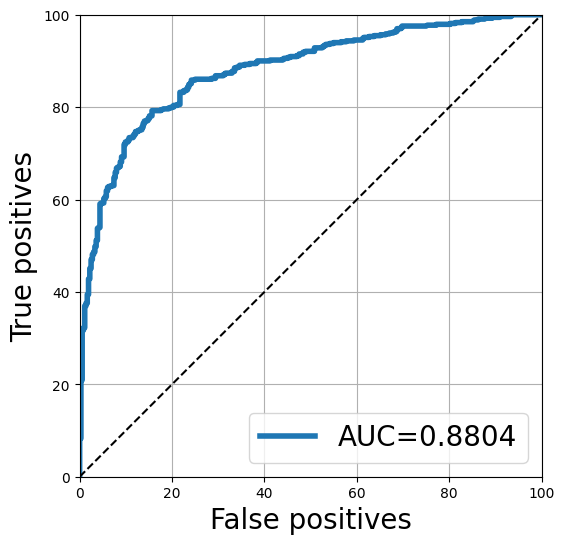

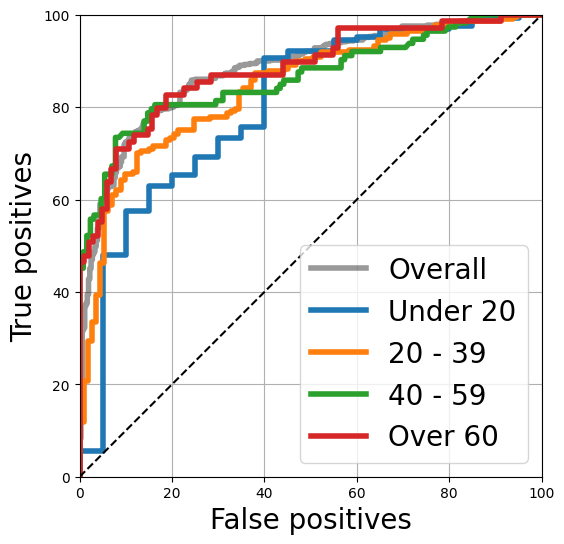

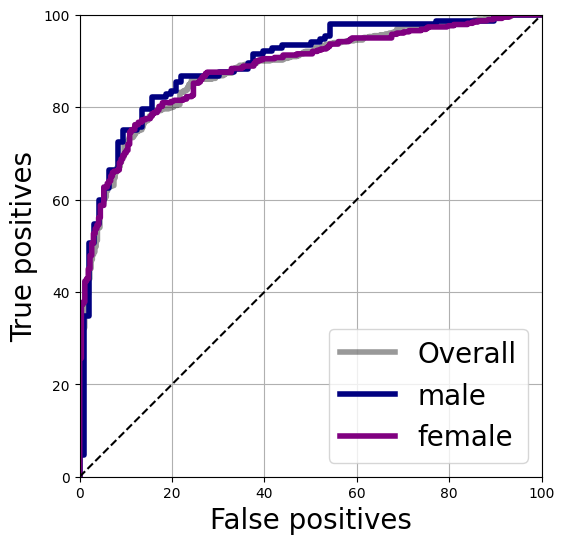

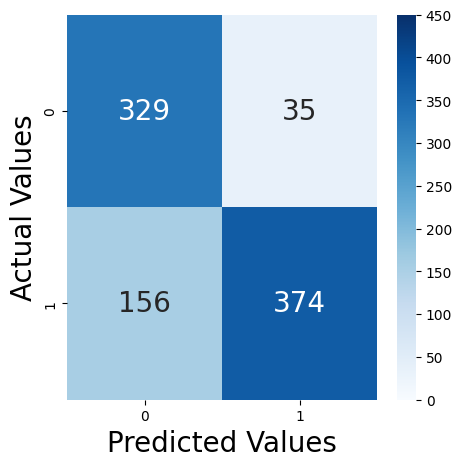

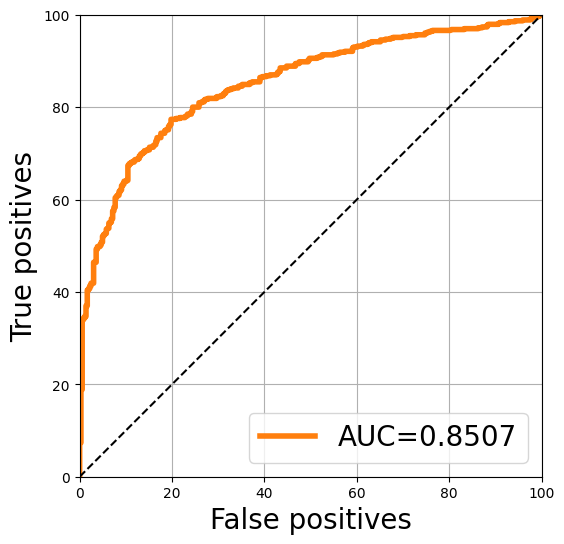

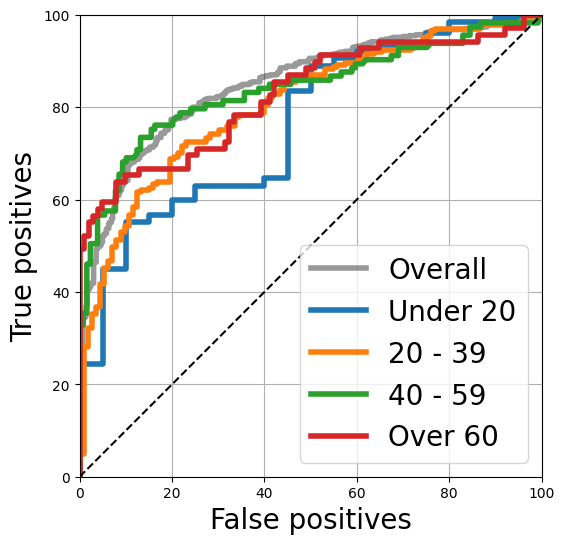

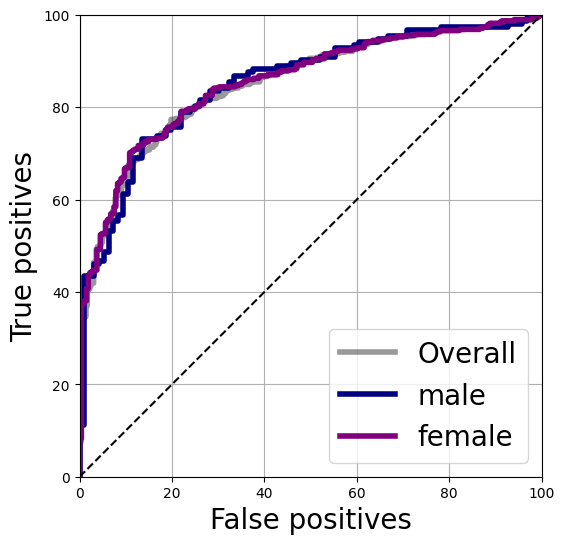

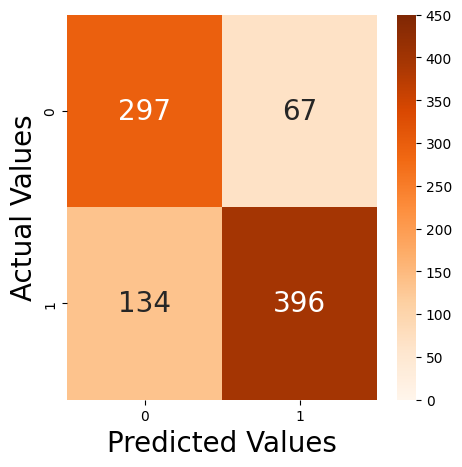

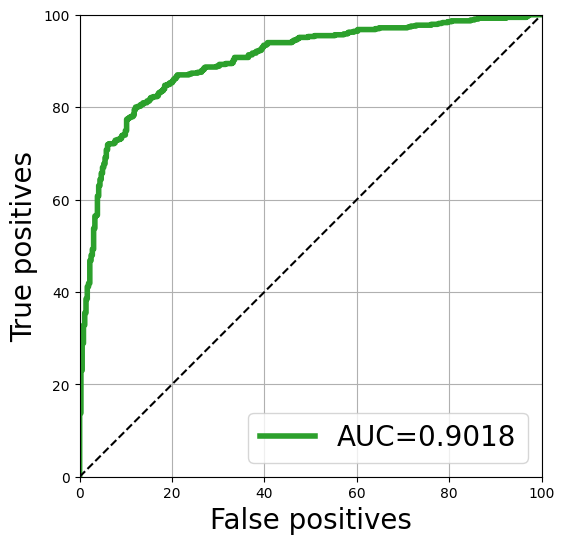

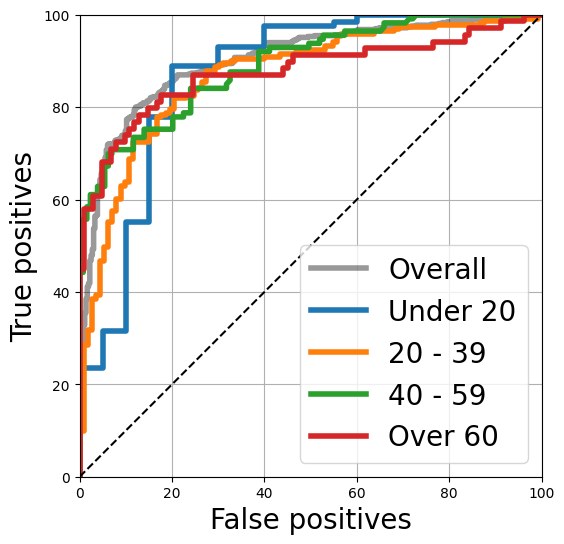

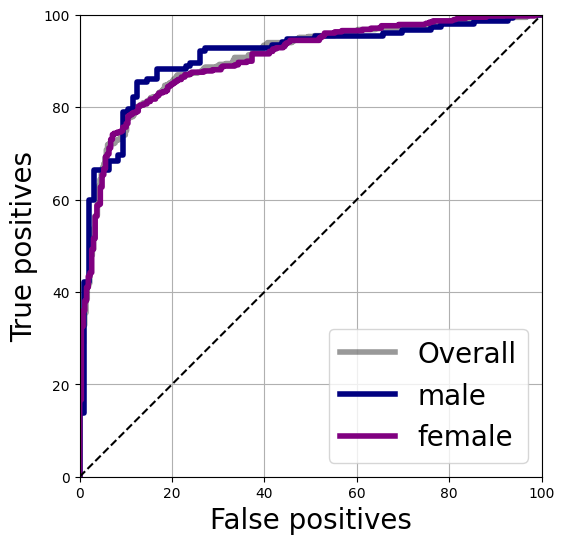

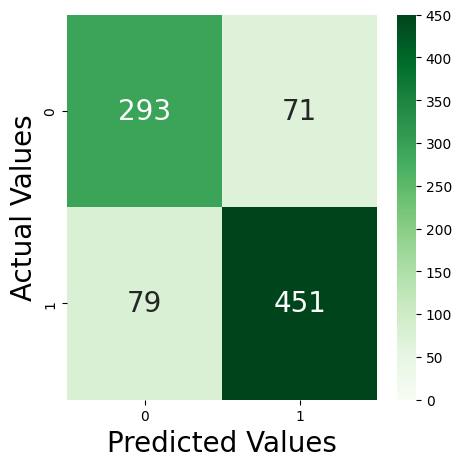

In [ ]:
save_graph("finetuning", colors[0], "Blues")
save_graph("freeze", colors[1], "Oranges")
save_graph("simple_224", colors[2], "Greens")

1/1 [==============================] - 3s 3s/step
sparsity: 0.9285514987244898


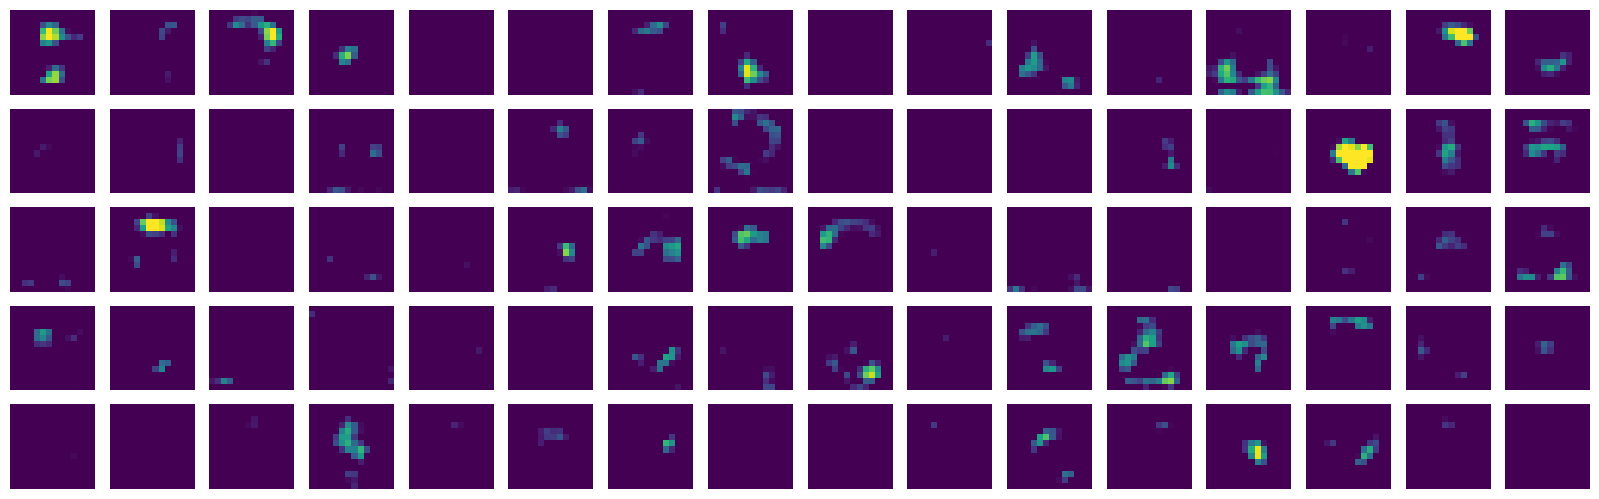

1/1 [==============================] - 0s 175ms/step
sparsity: 0.46799266581632654


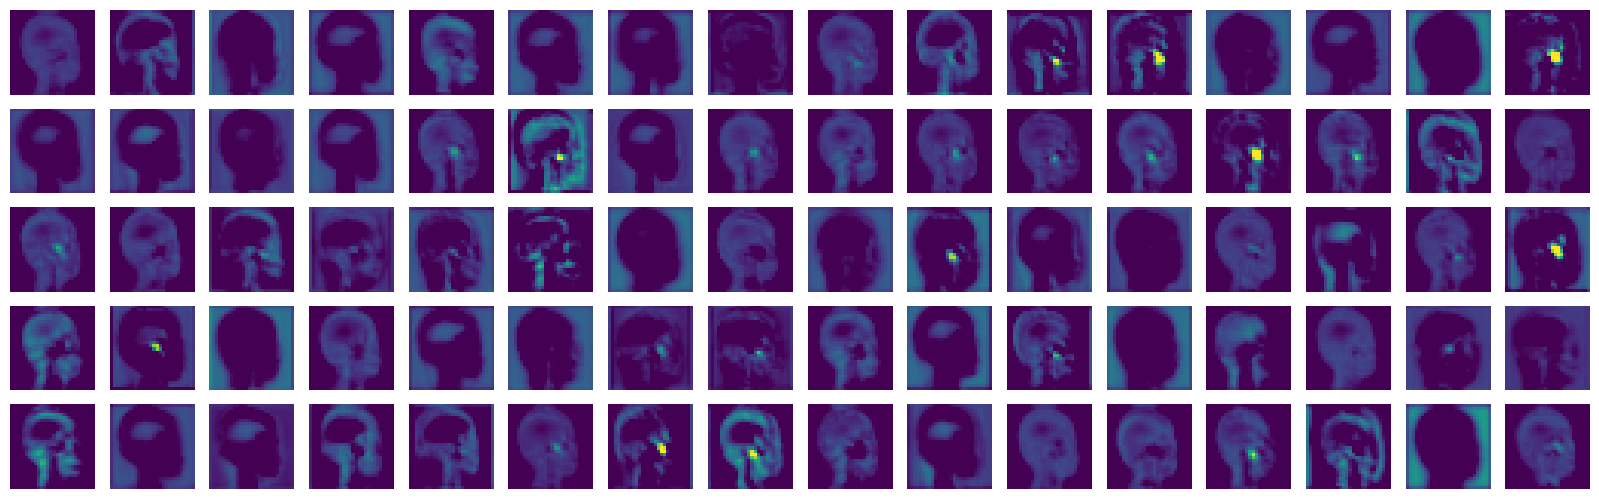

In [ ]:
# @title show last channel activation map

# finetuning, freeze, simple_224, _ = load_models()
act_model = grad_model = keras.models.Model(
        [finetuning.inputs], [finetuning.layers[-6].output]
    )
feature_maps = act_model.predict(test_X[10:11])
m = np.max(feature_maps)
print(f"sparsity: {np.sum(feature_maps <= 0)/ sum(feature_maps.flatten().shape) }")

trg_path = Path(figure_dir)
plt.figure(figsize=(16.1, 5.1))
for i in range(0, 80):
    ax = plt.subplot(5, 16, i+1)
    ax.matshow(feature_maps[0, :, :, i], vmin=0, vmax=m/3)
    ax.axis('off')
plt.tight_layout()
plt.savefig(trg_path.joinpath("finetuning_last_channel_activation_map.png"))
plt.show()
act_model = grad_model = keras.models.Model(
        [simple_224.inputs], [simple_224.layers[-4].output]
    )
feature_maps = act_model.predict(test_X[10:11])
print(f"sparsity: {np.sum(feature_maps <= 0)/ sum(feature_maps.flatten().shape) }")
m = np.max(feature_maps)
plt.figure(figsize=(16.1, 5.1))

for i in range(0, 80):
    ax = plt.subplot(5, 16, i+1)
    ax.matshow(feature_maps[0, :, :, i], vmin=0, vmax=m/3)
    ax.axis('off')
plt.tight_layout()
plt.savefig(trg_path.joinpath("simple_last_channel_activation_map.png"))
plt.show()



In [ ]:
# @title gradcam
import matplotlib.cm as cm
import cv2
import colorsys
import colorsys
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf
from PIL import Image


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass. Note that `training` is set to False.
        # This ensures that the model's layers are in inference mode.
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        # Since we are interested in the positive class (class "1"), we select the output probability
        # for the positive class, which is the model's output directly in binary classification.
        class_channel = preds[:, 0]

    # Compute gradients of the class (positive class) w.r.t. the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #pooled_grads = tf.maximum(pooled_grads, 0)

    # Weight the output feature map with the computed pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap to make the values between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def gradcam_with_img(img, heatmap, alpha=0.4):

    def cut(x):
        return 0 if x < 70 else x

    heatmap = np.uint8(255 * heatmap)
    heatmap = np.vectorize(cut)(heatmap)
    #히트맵을 위한 칼라맵 설정

    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # cmap2 = get_cmap2()
    # jet_heatmap = cmap2[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]), Image.BILINEAR)
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)


    superimposed_img = img*(1-alpha)
    superimposed_img += (jet_heatmap)*alpha
    superimposed_img = np.clip(superimposed_img, 0, 255)
    superimposed_img = np.uint8(superimposed_img)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

def gradcam_scale(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_sum(grads, axis=(0, 1, 2))

    # Weight the output feature map with the computed pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    return np.max(heatmap), np.min(heatmap)



(-0.5, 27.5, 27.5, -0.5)

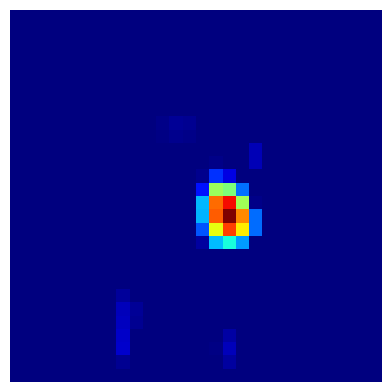

In [ ]:
heatmap = make_gradcam_heatmap(test_X[10:11], simple_224, 're_lu_17')
plt.matshow(heatmap, cmap='jet')
plt.axis("off")

In [ ]:

TP = np.where(np.logical_and(test_y[:50], scores["simple_224"][:50,0] > y_threshold))
FN = np.where(np.logical_and(test_y[:50], scores["simple_224"][:50,0] < y_threshold))
TN = np.where(np.logical_and(1-test_y[:50], scores["simple_224"][:50,0] < y_threshold))
FP = np.where(np.logical_and(1-test_y[:50], scores["simple_224"][:50,0] > y_threshold))
print(TP)
print(TN)
print("FP")
print(FP)

(array([ 1,  4,  6,  7, 10, 16, 17, 22, 24, 25, 26, 27, 31, 33, 37, 38, 42,
       43, 45, 47, 48, 49]),)
(array([ 0,  8,  9, 13, 19, 28, 35, 36, 39]),)
FP
(array([ 2,  3, 11, 12, 14, 15, 18, 20, 21, 23, 29, 30, 32, 34, 41, 44, 46]),)


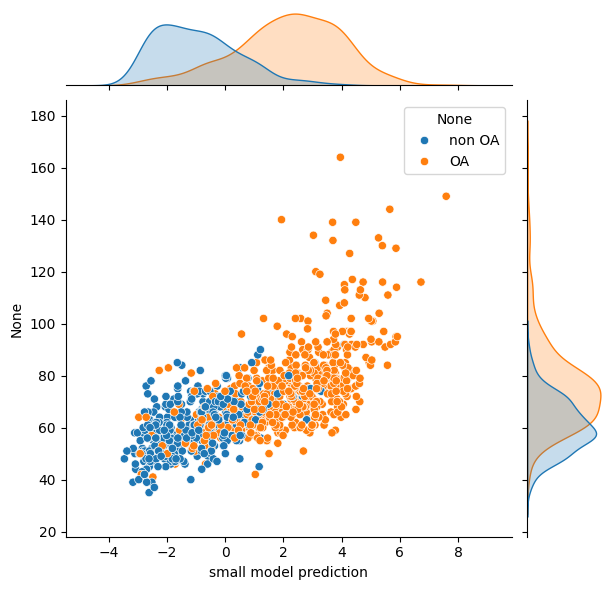

In [ ]:
sns.jointplot(data = data, y = test["tmjs"].squeeze(), x="small model prediction", hue=data["label"])

In [ ]:
num = 800

for i in range(num):
    gradcam_img = new_gcam(test_X[i:i+1], simple_224, 're_lu_17', 6)
    filename = figure_dir + "new_gcam/small_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)


In [ ]:
num = 240
indices = np.arange(num)[np.logical_and(test_y[:num]==1, scores["simple_224"][:num].squeeze() >models["simple_224"].threshold)]
heatmaps = np.zeros((num, 28, 28))
for i in indices:
    heatmap = make_gradcam_heatmap(test_X[i:i+1], simple_224, 're_lu_17')
    heatmaps[i] = heatmap

for i in indices:
    gradcam_img = gradcam_with_img(test_X[i], heatmaps[i], alpha=0.5)
    filename = figure_dir + "gradcam/simple_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)

indices = np.arange(num)[np.logical_and(test_y[:num]==1, scores["finetuning"][:num].squeeze() >models["finetuning"].threshold)]
heatmaps = np.zeros((num, 14, 14))
for i in indices:
    heatmap = make_gradcam_heatmap(test_X[i:i+1], finetuning, 'block5_conv3')
    heatmaps[i] = heatmap

for i in indices:
    gradcam_img = gradcam_with_img(test_X[i], heatmaps[i], alpha=0.5)
    filename = figure_dir + "gradcam/fine_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)